In [ ]:
!pwd

/content


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('train_rul.csv',sep=",")

In [ ]:
#check no garbage in RUL
for index, row in data.iterrows():
  if data.at[index, 'RUL'] < 0:
    print(index)
    print(data.at[index, 'RUL'])

In [ ]:
#read test
data_challenge = pd.read_csv('test.csv',sep=",")

In [ ]:
#build the RUL list in train data
engine_old = 1
cycle_old = 1
RUL = []
for index, row in data.iterrows():
  engine = row['Engine']
  cycle = row['Cycle']
  if engine > engine_old :
    RUL.append(cycle_old)
    engine_old = engine
    cycle_old = cycle
  else:
    cycle_old = cycle
#add the last cycle to RUL
RUL.append(data['Cycle'].iloc[-1])





In [ ]:
#build last_cycle list from testing data
engine_old = 1
cycle_old = 1
last_cycle = []
for index, row in data_challenge.iterrows():
  engine = row['Engine']
  cycle = row['Cycle']
  if engine > engine_old :
    last_cycle.append(cycle_old)
    engine_old = engine
    cycle_old = cycle
  else:
    cycle_old = cycle
last_cycle.append(data_challenge['Cycle'].iloc[-1])   

Model concept:


1.   Split training set into 15-step chunks
2.   Y is the RUL of the last step - 1
3.   Implement a custom loss function



In [ ]:
time_steps = 15



In [ ]:
list_of_columns = []
for j in range(6,27):
  list_of_columns.append(data.columns[j])


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed

In [ ]:
#load dataset to numpy
dataset = data.to_numpy()
X = dataset[:,2:27]
Y = dataset[:,27]

In [ ]:
Y_full = np.empty(224)
for i in range(224):
  Y_full[i] = 223 - i 

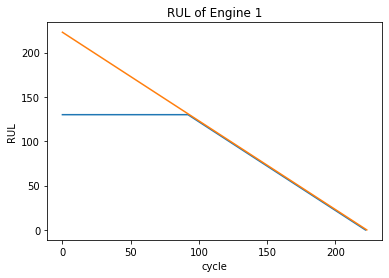

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('cycle')
plt.ylabel('RUL')
plt.title('RUL of Engine 1')
plt.plot(Y[0:223])
plt.plot(Y_full)

In [ ]:
# pearson's correlation feature selection for numeric input and numeric output

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# define feature selection
fs = SelectKBest(score_func=f_regression, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, Y)
print(X_selected.shape)

(45918, 10)


In [ ]:
features = X_selected.shape[1]

Pearson selected: Cycle, Sensor 3, Sensor 4, Sensor 9, Sensor 11, Sensor 14, Sensor 15, Sensor 16, Sensor 17, Sensor 21


In [ ]:
def build_data(time_steps, X, Y, RUL):
  #counter for how many samples this model will have (first dimension in X)
  samples = 0
  engines = len(RUL)
  for i in range(0,engines):
    samples = samples + int(RUL[i])//time_steps

 #reshape X into X(samples,time_steps,features)
 #make sure not to overlap between engines
 #reshape Y into Y(samples,1)
  features = X.shape[1]
  X_new=np.empty(shape=(samples,time_steps,features))
  Y_new = np.empty(shape=(samples,1))
  counter = -1
  sample = 0
  for i in range(0,engines):  
    engine = data.at[counter+1,'Engine']-1
    cycles = int(RUL[engine])//time_steps
    counter0 = counter
    for cycle in range(0,cycles):
      for j in range(0,time_steps):
        if (cycles == 1):
          margin = int((RUL[i]-time_steps)/2)
          if (j == 0):
            counter0 = counter
            counter = counter0 +  margin -1
          else: 
            counter = counter + 1
        else:
           counter = counter + 1
        for k in range(0,features):
          X_new[sample,j,k]=X[counter,k]
          
        if (j == time_steps - 1):
          Y_new[sample,] = Y[counter]-1
 

        if (j == time_steps-1 and cycle == cycles-1):
           counter = counter0 + int(RUL[engine])

      sample = sample + 1
    
  return X_new, Y_new



In [ ]:
X_new, Y_new = build_data(time_steps, X_selected, Y, RUL)

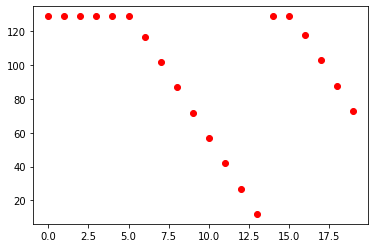

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Y_new[0:20], "ro")

In [ ]:
 from sklearn.model_selection import train_test_split
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.33)

In [ ]:
def scale_and_transform(X_train, X_test, scaler):
  num_instances, num_time_steps, num_features = X_train.shape
  X_train_for_fit = np.reshape(X_train, (-1, num_features))
  Xn_train_for_fit = scaler.fit_transform(X_train_for_fit)
  Xn_train = np.reshape(Xn_train_for_fit, (num_instances, num_time_steps, num_features))

  num_instances, num_time_steps, num_features = X_test.shape
  X_test_for_fit = np.reshape(X_test, (-1, num_features))
  Xn_test_for_fit = scaler.transform(X_test_for_fit)
  Xn_test = np.reshape(Xn_test_for_fit, (num_instances, num_time_steps, num_features))
  return Xn_train, Xn_test

In [ ]:
#let's normalize this thing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

Xn_train, Xn_test = scale_and_transform(X_train, X_test, scaler)


In [ ]:
#build model
from keras.backend import clear_session
clear_session()
model = Sequential()
model.add(InputLayer(input_shape=(time_steps,features)))

model.add(LSTM(64,  return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))

model.add(Dense(1,activation='linear'))


In [ ]:

model.compile('adam','mae')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 64)            19200     
_________________________________________________________________
dropout (Dropout)            (None, 15, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________


**Training Model with MAE**

In [ ]:
#train large model
EPOCHS = 10
BS = 20
model.fit(Xn_train,y_train,batch_size=BS,epochs=EPOCHS)
model.evaluate(Xn_test,y_test)
y_new = model.predict(Xn_test)

Epoch 1/10
100/100 [==============================] - 2s 16ms/step - loss: 12.1657
Epoch 2/10
100/100 [==============================] - 2s 16ms/step - loss: 12.3143
Epoch 3/10
100/100 [==============================] - 2s 16ms/step - loss: 12.2137
Epoch 4/10
100/100 [==============================] - 2s 16ms/step - loss: 12.2912
Epoch 5/10
100/100 [==============================] - 2s 15ms/step - loss: 12.3378
Epoch 6/10
100/100 [==============================] - 2s 16ms/step - loss: 11.6425
Epoch 7/10
100/100 [==============================] - 2s 16ms/step - loss: 11.8828
Epoch 8/10
100/100 [==============================] - 2s 16ms/step - loss: 11.9041
Epoch 9/10
100/100 [==============================] - 2s 17ms/step - loss: 11.7055
Epoch 10/10
31/31 [==============================] - 0s 6ms/step - loss: 12.4561


In [ ]:
model.save('model_mae_best_weights')

INFO:tensorflow:Assets written to: model_mae_best_weights/assets


INFO:tensorflow:Assets written to: model_mae_best_weights/assets


In [ ]:
#model.evaluate(Xn_test,y_test)
from keras.models import load_model
model_saved = load_model("model_best_latest_weights")
model_saved = load_model("model_best_latest_weights")
model_saved.evaluate(Xn_test_large,y_test_large)
y_new_large = model_saved.predict(Xn_test_large)

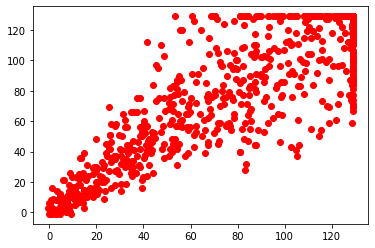

In [ ]:
import matplotlib.pyplot as plt
n = 6
plt.plot(y_new, y_test, "ro")


In [ ]:
!tar -zcvf model_mae_best_weights.gz model_mae_best_weights

tar: model_mae_best_weights: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


**Apply large model to the challenge data**

In [ ]:
engine_old = 1
cycle_old = 1
last_cycle = []
for index, row in data_challenge.iterrows():
  engine = row['Engine']
  cycle = row['Cycle']
  if engine > engine_old :
    last_cycle.append(cycle_old)
    engine_old = engine
    cycle_old = cycle
  else:
    cycle_old = cycle
last_cycle.append(data_challenge['Cycle'].iloc[-1])   

In [ ]:
test_cases = len(last_cycle)

In [ ]:
#read test
data_challenge = pd.read_csv('test.csv',sep=",")

In [ ]:
dataset_challenge = data_challenge.to_numpy()
X_valid = dataset_challenge[:,1:]

In [ ]:
X_valid.shape

(29820, 25)

In [ ]:
X_valid_reduced = fs.transform(X_valid)

In [ ]:
X_valid_reduced.shape

(29820, 10)

In [ ]:
#apply minimax
Xn_valid = scaler.transform(X_valid_reduced)

In [ ]:
#need to reshape X into 3D: engine x cycle x sensor
#for fist step, keep it symmetrical and use the lowest number of cycles in dataset
#Y then becomes 
Xn_valid_3d=np.empty(shape=(len(last_cycle),time_steps,features))

#i would be number of engines
counter = 0
for i in range(0,len(last_cycle)):
  print('i=',i)
  # j would be number of cycles
  for j in range(0,time_steps):

    #k would be number of sensors
    for k in range(0,features):

      Xn_valid_3d[i,j,k]=Xn_valid[counter,k]

    if j == 0:
      counter = counter + (int(last_cycle[i]) - time_steps)
      print('counter at j=0',counter)
    else: 
      counter = counter + 1

In [ ]:
y_valid = model_saved_custom.predict(Xn_valid_3d)

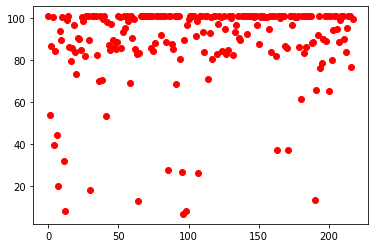

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_valid, "ro")

(array([  3.,   4.,   6.,   2.,   3.,  10.,  58., 132.,   0.,   0.]),
 array([  0.,  13.,  26.,  39.,  52.,  65.,  78.,  91., 104., 117., 130.],
       dtype=float32),
 <a list of 10 Patch objects>)

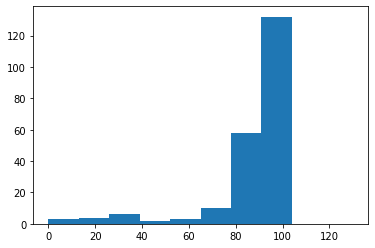

In [ ]:
plt.hist(y_valid, bins = 10, range = (0,130))

In [ ]:
RUL_predicted = []
for i in range(y_valid.shape[0]):
  RUL_predicted.append(int(round(y_valid[i,0])))


In [ ]:
with open('lmst_mae_last_cycle.txt', 'w') as filehandle:
    for item in RUL_predicted:
        filehandle.write('%s\n' % item)

**Model with Custom Loss Function**

In [ ]:
#build model
from keras.backend import clear_session
clear_session()
model_custom = Sequential()
model_custom.add(InputLayer(input_shape=(time_steps,features)))

model_custom.add(LSTM(64,  return_sequences=True))
model_custom.add(Dropout(0.5))
model_custom.add(LSTM(64,  return_sequences=True))
model_custom.add(Dropout(0.5))
model_custom.add(LSTM(32,  return_sequences=True))
model_custom.add(Dropout(0.5))
model_custom.add(LSTM(32, return_sequences=False))

model_custom.add(Dense(1,activation='linear'))

In [ ]:
import keras.backend as kb

def custom_loss_function(y_actual, y_predicted):
  #d1 should be selected when y_predicted is too large, and scaled by 10
  d1 = (y_predicted - y_actual)/(10.) # batch_size, 1 (35 - 25) /(10) = 0.7629  or (55)
  #d2 should be selected when y_predicted is smaller than y_actual
  d2 = (y_predicted - y_actual)/(-13.) #batch_size, 1.  (25 - 35 ) / (-13) > 0
  #kb.maximum selects the larger one element-wise. for each element of d1 or d2 
  #only one should be positive
  d = kb.maximum(d1,d2) #batch_size, 1
  loss = kb.exp(d) - 1 
  #print(loss.shape)

  

  custom_loss_value = kb.sum(loss)
  
  return custom_loss_value

In [ ]:
import keras.backend as kb

def custom_loss_function(y_actual, y_predicted):
  d1 = (y_predicted - y_actual)/(10.) 
  d2 = (y_predicted - y_actual)/(-13.) 
  d = kb.maximum(d1,d2) 
  loss = kb.exp(d) - 1 
  custom_loss_value = kb.sum(loss) 
  return custom_loss_value

In [ ]:

model_custom.compile('adam',loss=custom_loss_function)

model_custom.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 64)            19200     
_________________________________________________________________
dropout (Dropout)            (None, 15, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 32)            12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8

In [ ]:
#train large model
EPOCHS = 5
BS = 20
model_custom.fit(Xn_train,y_train,batch_size=BS,epochs=EPOCHS)
model_custom.evaluate(Xn_test,y_test)
y_new = model_custom.predict(Xn_test)

Epoch 1/5
100/100 [==============================] - 3s 33ms/step - loss: 156.5721
Epoch 2/5
100/100 [==============================] - 3s 33ms/step - loss: 156.9583
Epoch 3/5
100/100 [==============================] - 3s 32ms/step - loss: 153.5909
Epoch 4/5
100/100 [==============================] - 3s 32ms/step - loss: 155.8161
Epoch 5/5
31/31 [==============================] - 0s 9ms/step - loss: 374.4441


In [ ]:
model_custom.evaluate(Xn_test,y_test)


31/31 [==============================] - 0s 10ms/step - loss: 261.5799


261.5799255371094

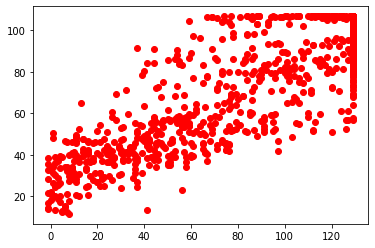

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_new, "ro")

In [ ]:
model_custom.save('model_custom_best_weights_2')

INFO:tensorflow:Assets written to: model_custom_best_weights_2/assets


INFO:tensorflow:Assets written to: model_custom_best_weights_2/assets


In [ ]:
!tar -xzvf model_custom_best_weights.gz

model_custom_best_weights/
model_custom_best_weights/saved_model.pb
model_custom_best_weights/assets/
model_custom_best_weights/variables/
model_custom_best_weights/variables/variables.index
model_custom_best_weights/variables/variables.data-00000-of-00001
model_custom_best_weights/keras_metadata.pb


In [ ]:
#load back best weights before it overfit
from keras import losses
losses.custom_loss = custom_loss_function

from keras.models import load_model
model_saved_custom = load_model("model_custom_best_weights", 
                                custom_objects={'custom_loss_function': custom_loss_function})
model_saved_custom.evaluate(Xn_test,y_test)
y_new = model_saved_custom.predict(Xn_test)

31/31 [==============================] - 16s 9ms/step - loss: 276.4115


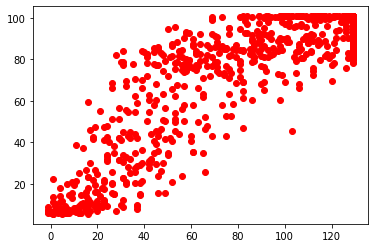

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_new, "ro")

predict y_valid using the saved weights

In [ ]:
y_valid_custom = model_saved_custom.predict(Xn_valid_3d)

NameError: ignored

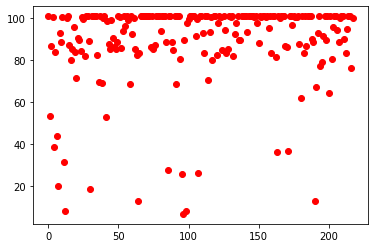

In [ ]:
import matplotlib.pyplot as plt






plt.plot(y_valid_custom, "ro")

In [ ]:
RUL_predicted_custom = []
for i in range(y_valid_custom.shape[0]):
  RUL_predicted_custom.append(int(round(y_valid_custom[i,0])))

In [ ]:
print(RUL_predicted_custom)

[101, 53, 87, 101, 39, 84, 44, 20, 93, 89, 101, 31, 8, 100, 101, 87, 80, 85, 96, 84, 72, 91, 90, 84, 101, 99, 82, 101, 101, 89, 19, 101, 101, 101, 101, 83, 69, 101, 69, 100, 101, 53, 99, 88, 85, 99, 90, 86, 85, 89, 101, 101, 86, 94, 101, 96, 101, 99, 69, 101, 92, 100, 85, 83, 13, 84, 101, 101, 101, 101, 101, 101, 101, 86, 101, 85, 87, 101, 101, 101, 94, 101, 101, 101, 89, 28, 101, 101, 88, 85, 101, 69, 101, 101, 80, 26, 7, 90, 8, 98, 100, 101, 101, 101, 101, 92, 100, 26, 101, 101, 93, 83, 101, 101, 70, 93, 101, 80, 101, 101, 83, 98, 101, 101, 85, 101, 95, 84, 85, 101, 101, 101, 82, 92, 97, 101, 90, 90, 101, 101, 101, 101, 93, 101, 101, 101, 101, 101, 101, 97, 88, 101, 101, 101, 101, 101, 101, 95, 101, 83, 101, 101, 82, 36, 101, 100, 101, 101, 101, 87, 86, 37, 101, 101, 97, 101, 101, 101, 101, 88, 62, 101, 83, 101, 87, 101, 101, 101, 90, 89, 13, 67, 93, 101, 77, 79, 92, 101, 90, 101, 64, 101, 81, 96, 101, 101, 94, 88, 100, 101, 101, 90, 84, 95, 101, 101, 76, 100]


In [ ]:
with open('lmst_custom.txt', 'w') as filehandle:
    for item in RUL_predicted_custom:
        filehandle.write('%s\n' % item)

LET"S TRY MSE


In [ ]:
#build model
from keras.backend import clear_session
clear_session()
model_mse = Sequential()
model_mse.add(InputLayer(input_shape=(time_steps,features)))

model_mse.add(LSTM(64,  return_sequences=True))
model_mse.add(Dropout(0.5))
model_mse.add(LSTM(64,  return_sequences=True))
model_mse.add(Dropout(0.5))
model_mse.add(LSTM(32,  return_sequences=True))
model_mse.add(Dropout(0.5))
model_mse.add(LSTM(32, return_sequences=False))

model_mse.add(Dense(1,activation='linear'))

In [ ]:
model_mse.compile('adam','mse')

model_mse.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 64)            19200     
_________________________________________________________________
dropout (Dropout)            (None, 15, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 32)            12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8

In [ ]:
#train large model
EPOCHS = 5
BS = 20
model_mse.fit(Xn_train,y_train,batch_size=BS,epochs=EPOCHS)
model_mse.evaluate(Xn_test,y_test)
y_new = model_mse.predict(Xn_test)

Epoch 1/5
100/100 [==============================] - 3s 33ms/step - loss: 323.2351
Epoch 2/5
100/100 [==============================] - 3s 32ms/step - loss: 309.2622
Epoch 3/5
100/100 [==============================] - 3s 33ms/step - loss: 293.2413
Epoch 4/5
100/100 [==============================] - 3s 33ms/step - loss: 295.0080
Epoch 5/5
31/31 [==============================] - 0s 10ms/step - loss: 351.8327


In [ ]:
model_mse.evaluate(Xn_test,y_test)

31/31 [==============================] - 0s 10ms/step - loss: 346.3233


346.3233337402344

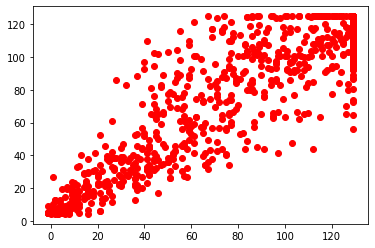

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_new, "ro")

In [ ]:
model_mse.save('model_mse_best_weights_2')

INFO:tensorflow:Assets written to: model_mse_best_weights_2/assets


INFO:tensorflow:Assets written to: model_mse_best_weights_2/assets


In [ ]:
!tar -zcvf model_custom_best_weights.gz model_custom_best_weights

model_custom_best_weights/
model_custom_best_weights/saved_model.pb
model_custom_best_weights/assets/
model_custom_best_weights/variables/
model_custom_best_weights/variables/variables.index
model_custom_best_weights/variables/variables.data-00000-of-00001
model_custom_best_weights/keras_metadata.pb


In [ ]:
!tar -zcvf model_mse_best_weights_2.gz model_mse_best_weights_2

model_mse_best_weights_2/
model_mse_best_weights_2/saved_model.pb
model_mse_best_weights_2/assets/
model_mse_best_weights_2/variables/
model_mse_best_weights_2/variables/variables.index
model_mse_best_weights_2/variables/variables.data-00000-of-00001
model_mse_best_weights_2/keras_metadata.pb


In [ ]:
#load weights from before overfitting


from keras.models import load_model
model_saved_mse = load_model("model_mse_best_weights_2")
model_saved_mse.evaluate(Xn_test,y_test)
y_new = model_saved_mse.predict(Xn_test)

31/31 [==============================] - 2s 10ms/step - loss: 346.3233


In [ ]:
y_valid_mse = model_saved_mse.predict(Xn_valid_3d)

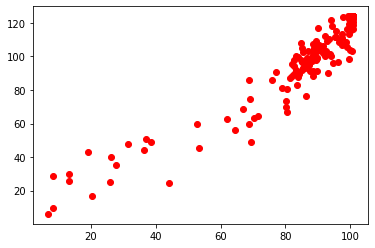

In [ ]:
import matplotlib.pyplot as plt


plt.plot(y_valid_custom, y_valid_mse, "ro")

In [ ]:
RUL_predicted_mse = []
for i in range(y_valid_mse.shape[0]):
  RUL_predicted_mse.append(int(round(y_valid_mse[i,0])))

In [ ]:
with open('lmst_mse.txt', 'w') as filehandle:
    for item in RUL_predicted_mse:
        filehandle.write('%s\n' % item)